In [1]:
import torch
from torch import optim
from torch.utils.data import random_split

from models import SmallUNet, BigUNet
from datasets import SegmentationDataset, PerturbedSegmentationDataset, SegmentationGaussianDataset
from loss import DiceLoss
# from trainer import train
from metrics import calculate_dice_score

import matplotlib.pyplot as plt

In [2]:

def visualize_results(model, data_loader, device, epoch, save_path='./visualizations'):
    """
    Visualize model predictions against ground truth for a batch of images.
    
    Args:
        model: The trained model
        data_loader: DataLoader containing the validation/test data
        device: Device to run the model on
        epoch: Current epoch number
        save_path: Directory to save the visualization plots
    """
    import os
    os.makedirs(save_path, exist_ok=True)
    
    model.eval()
    with torch.no_grad():
        # Get a batch of data
        images, labels = next(iter(data_loader))
        images, labels = images.to(device), labels.to(device)
        
        # Get model predictions
        outputs = model(images)
        predictions = (outputs > 0.5).float()
        
        # Create a figure with a grid of subplots
        num_samples = min(4, images.shape[0])  # Show up to 4 samples
        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
        
        for idx in range(num_samples):
            # Original image
            axes[idx, 0].imshow(images[idx, 0].cpu().numpy(), cmap='gray')
            axes[idx, 0].set_title('Input Image')
            axes[idx, 0].axis('off')
            
            # Ground truth
            axes[idx, 1].imshow(labels[idx, 0].cpu().numpy(), cmap='gray')
            axes[idx, 1].set_title('Ground Truth')
            axes[idx, 1].axis('off')
            
            # Model prediction
            axes[idx, 2].imshow(predictions[idx, 0].cpu().numpy(), cmap='gray')
            axes[idx, 2].set_title('Model Prediction')
            axes[idx, 2].axis('off')
        
        plt.tight_layout()
        plt.show()

In [3]:
def train(model, train_loader, criterion, optimizer, device, num_epochs):
    """
    Training function with visualization every 10 epochs.
    
    Args:
        model: The model to train
        train_loader: DataLoader containing the training data
        criterion: Loss function
        optimizer: Optimizer
        device: Device to run the training on
        num_epochs: Number of epochs to train for
    """
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        # Print epoch statistics
        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        
        # Visualize results every 10 epochs
        if (epoch + 1) % 10 == 0:
            visualize_results(model, train_loader, device, epoch + 1)
            model.train()  # Set back to training mode

Epoch [1/50], Loss: 0.7789
Epoch [2/50], Loss: 0.6873
Epoch [3/50], Loss: 0.6739
Epoch [4/50], Loss: 0.6573
Epoch [5/50], Loss: 0.6403
Epoch [6/50], Loss: 0.6166
Epoch [7/50], Loss: 0.6304
Epoch [8/50], Loss: 0.5932
Epoch [9/50], Loss: 0.6054
Epoch [10/50], Loss: 0.5784


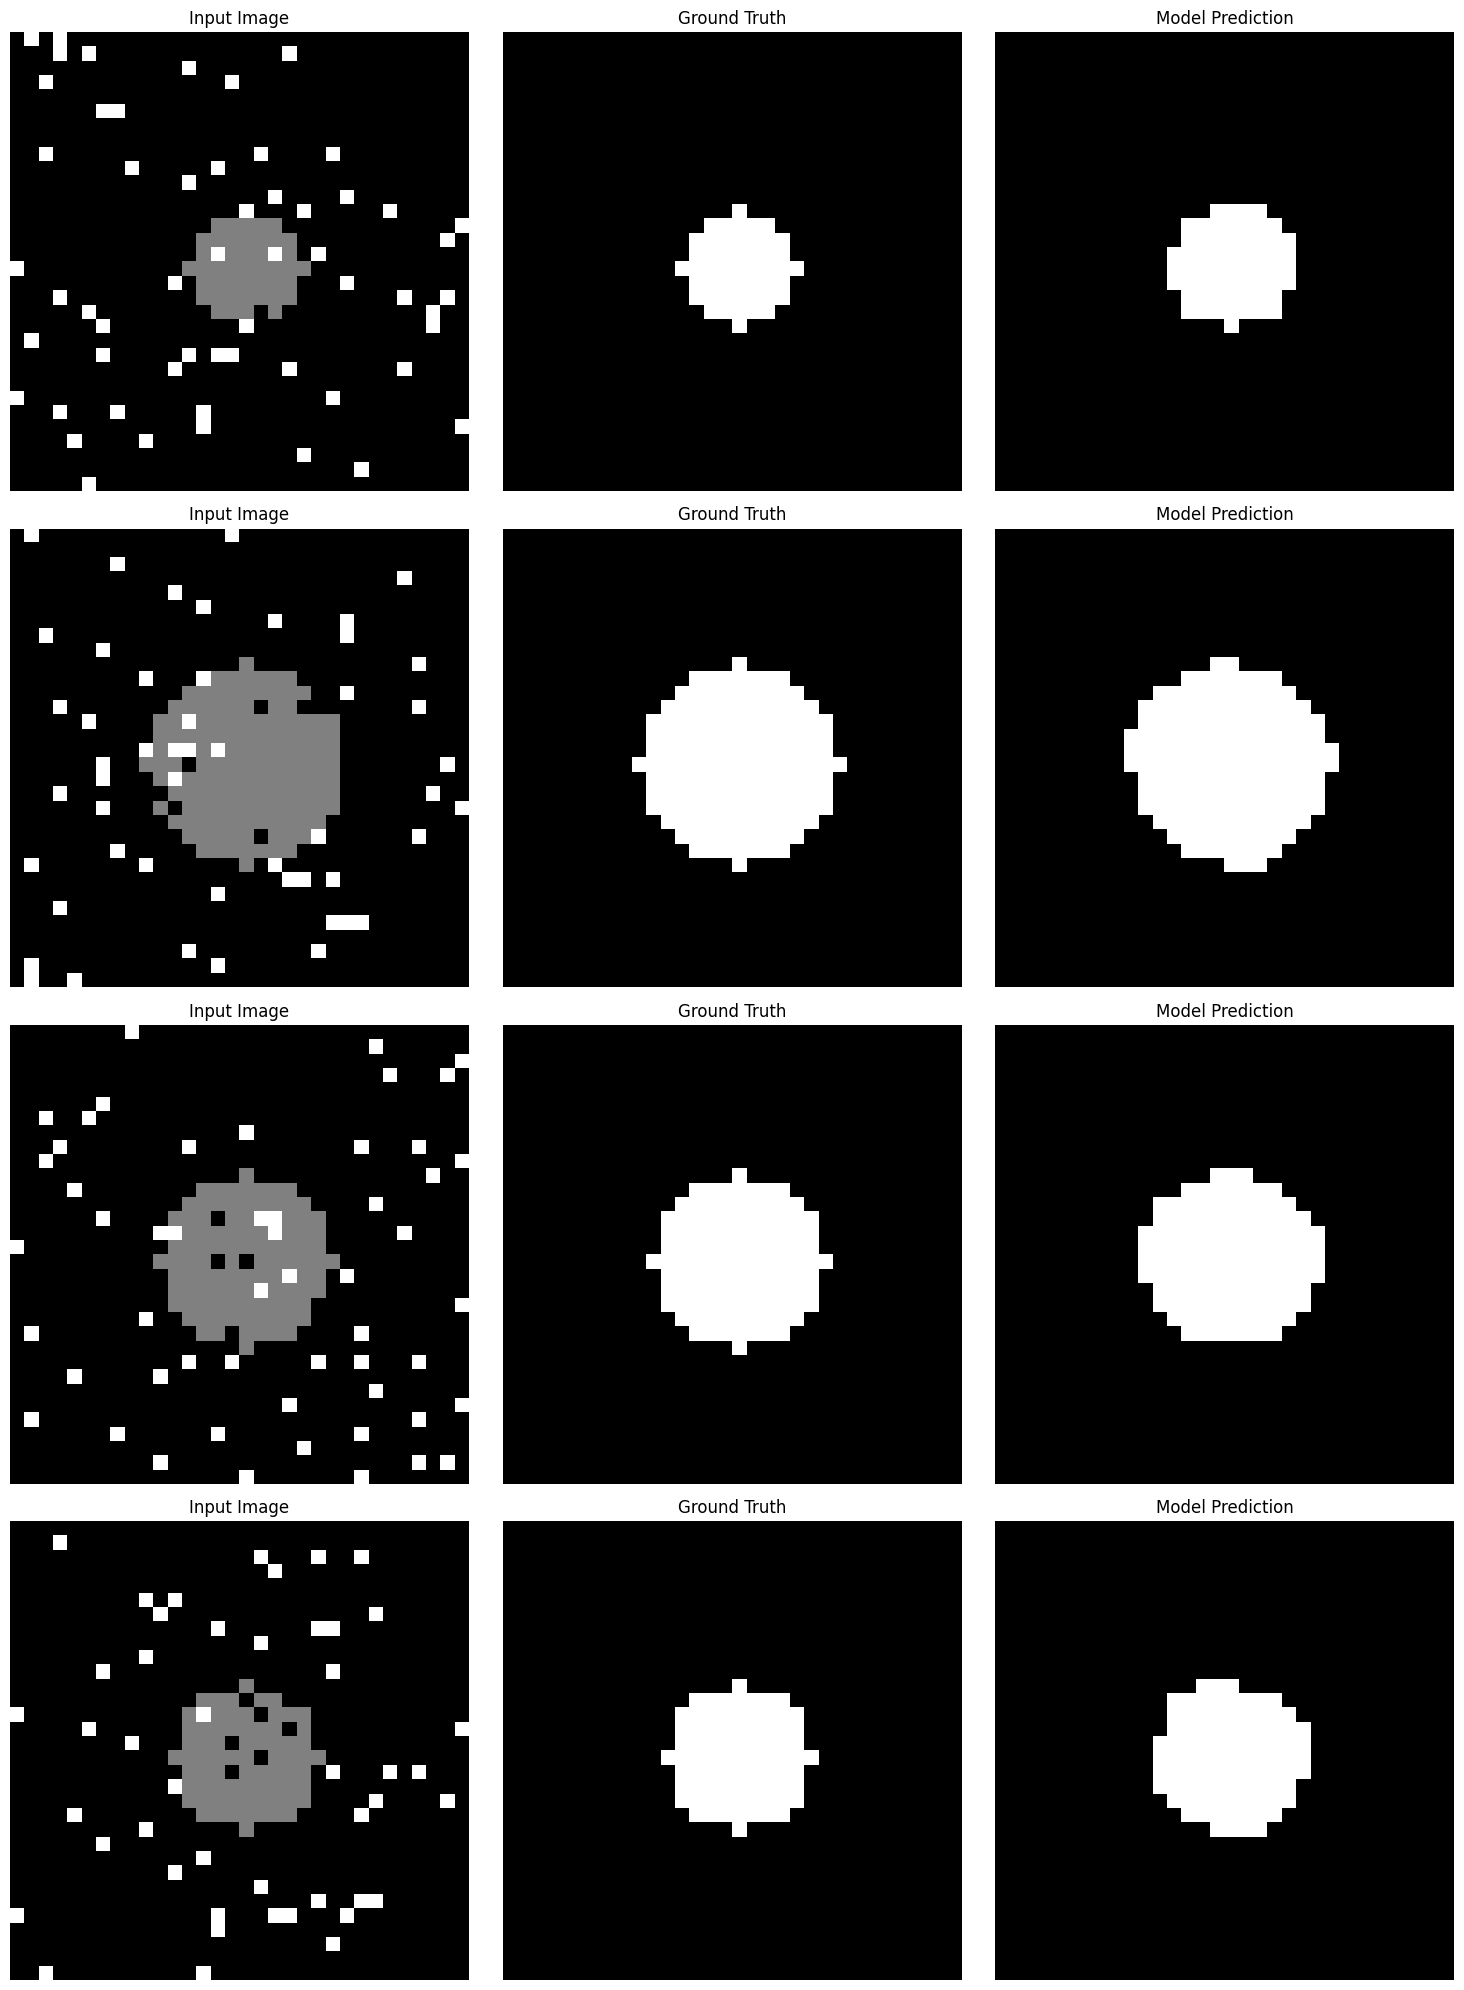

Epoch [11/50], Loss: 0.5741
Epoch [12/50], Loss: 0.5627
Epoch [13/50], Loss: 0.5545
Epoch [14/50], Loss: 0.5322
Epoch [15/50], Loss: 0.5063
Epoch [16/50], Loss: 0.5093
Epoch [17/50], Loss: 0.4865
Epoch [18/50], Loss: 0.5114
Epoch [19/50], Loss: 0.4910
Epoch [20/50], Loss: 0.4453


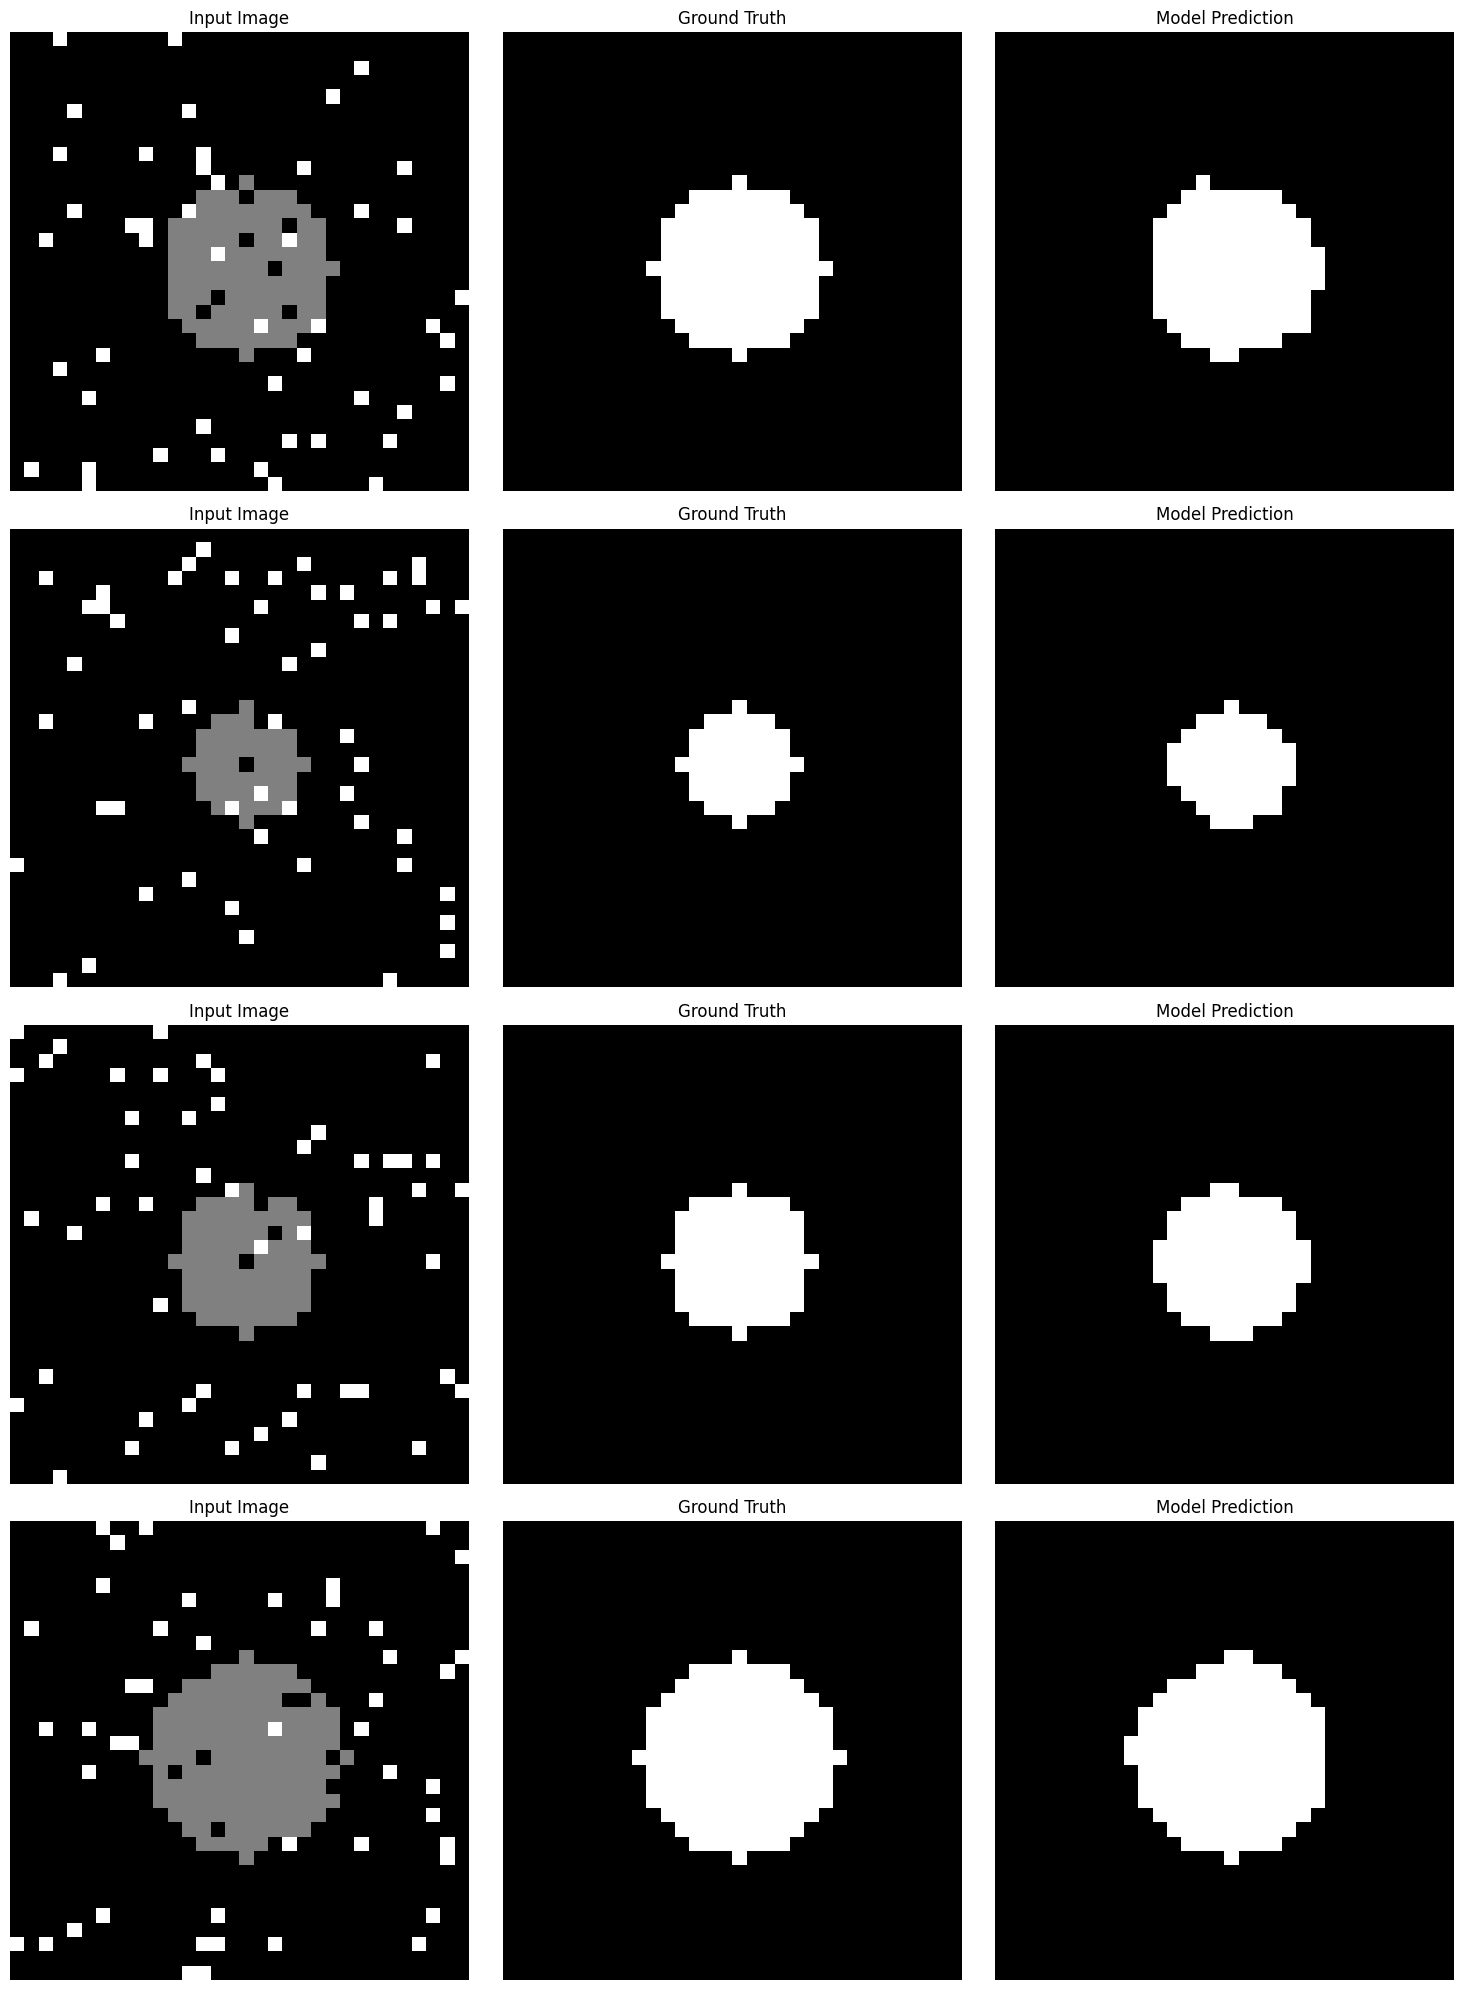

Epoch [21/50], Loss: 0.4645
Epoch [22/50], Loss: 0.4558
Epoch [23/50], Loss: 0.4146
Epoch [24/50], Loss: 0.4063
Epoch [25/50], Loss: 0.3924
Epoch [26/50], Loss: 0.3870
Epoch [27/50], Loss: 0.3520
Epoch [28/50], Loss: 0.3636
Epoch [29/50], Loss: 0.3427
Epoch [30/50], Loss: 0.3315


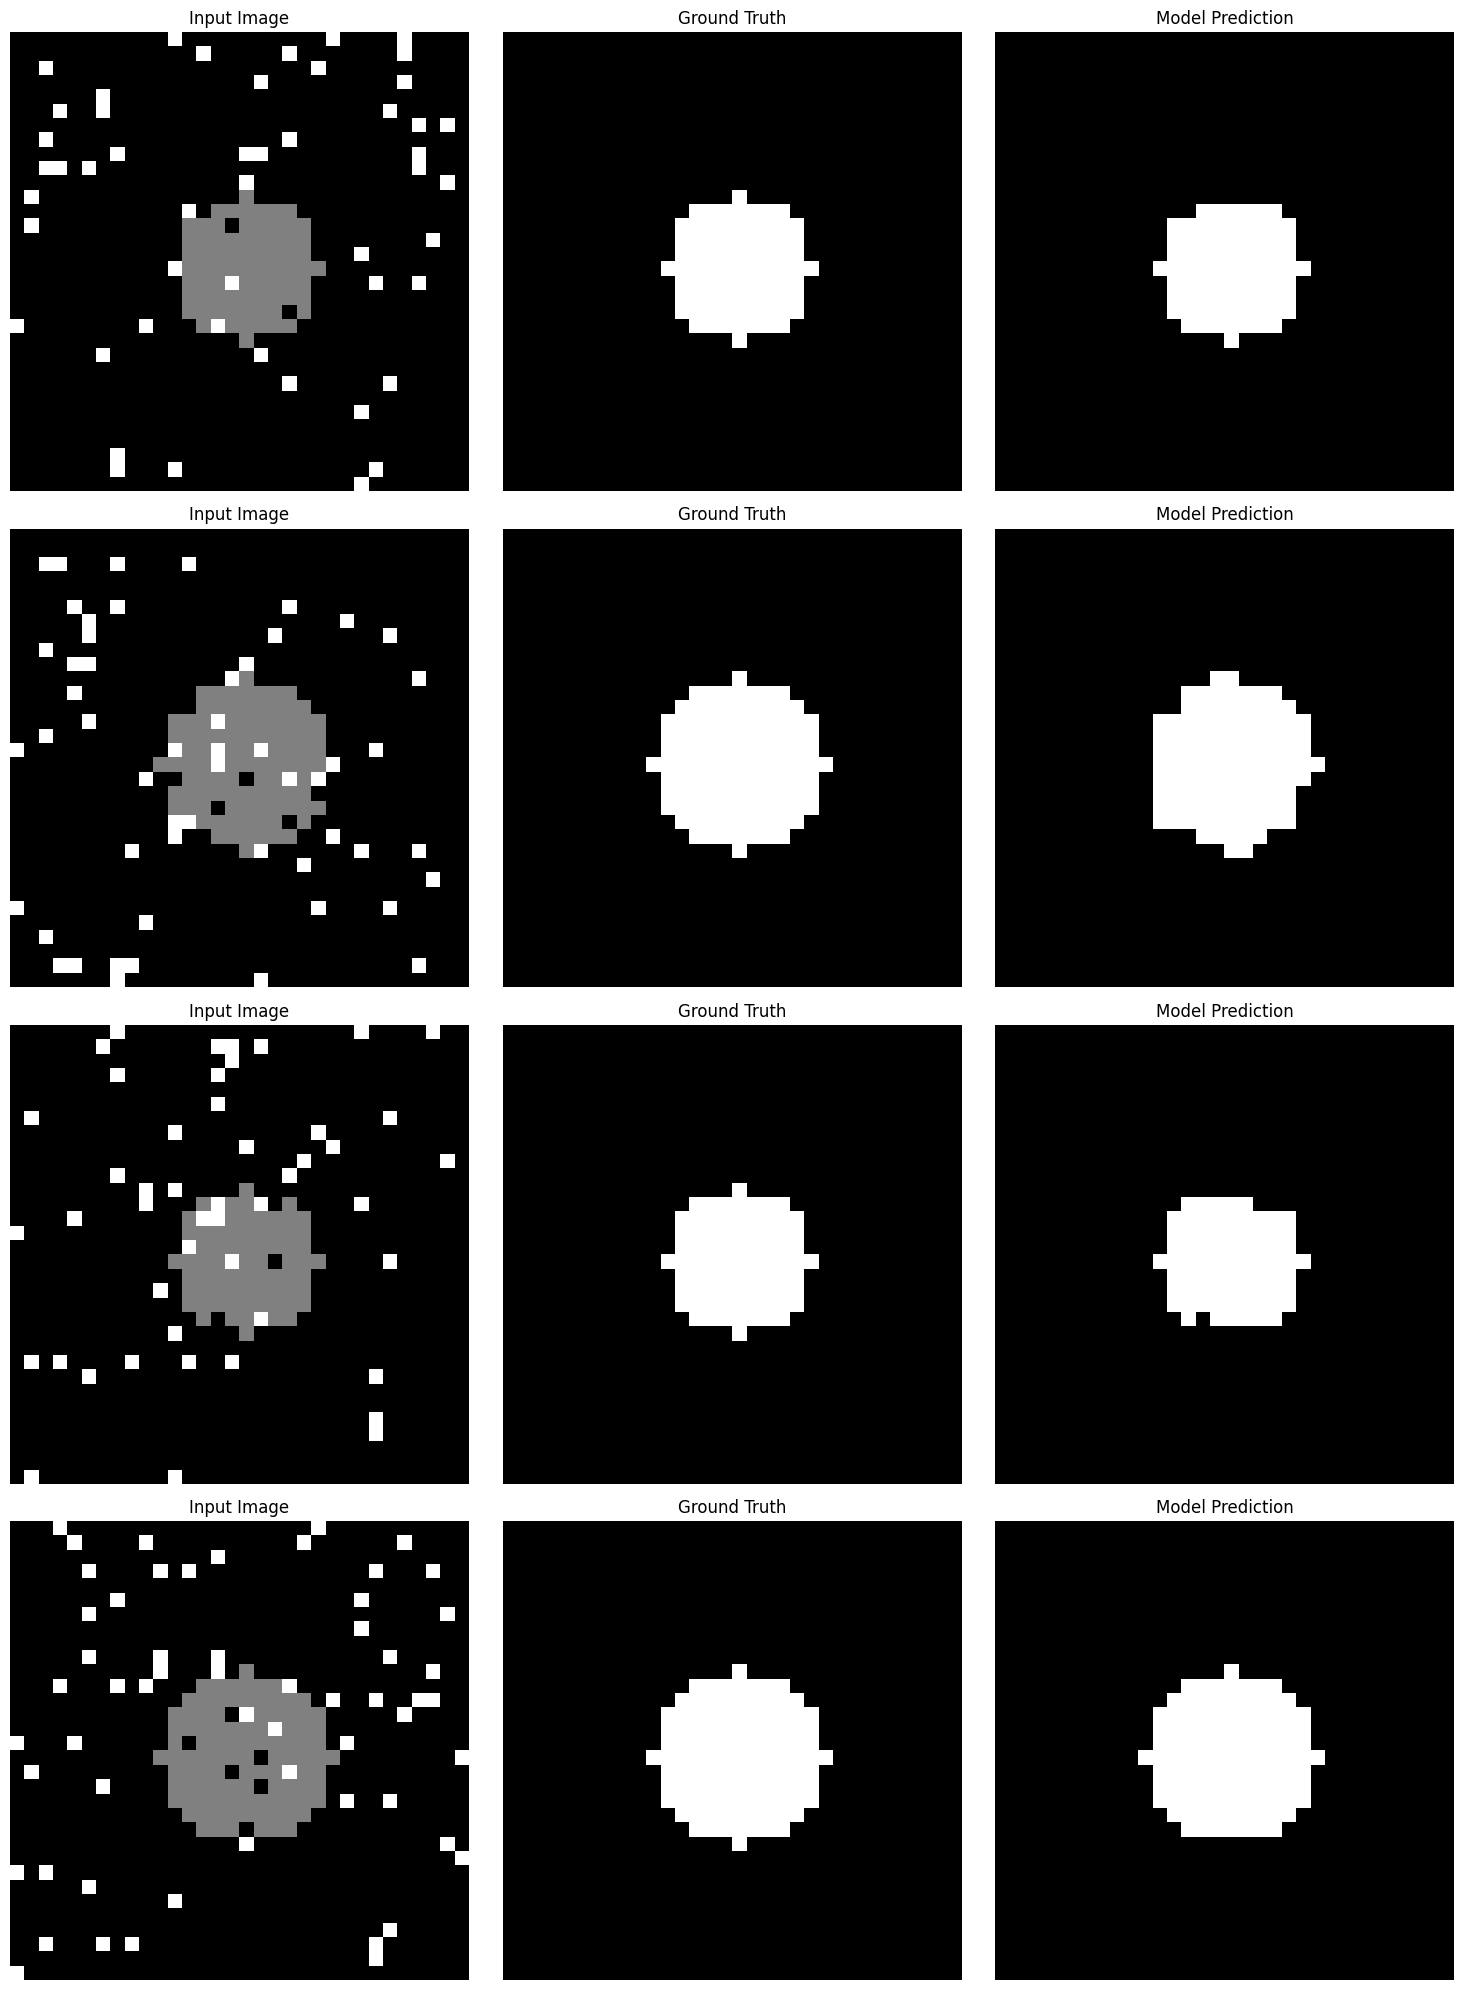

Epoch [31/50], Loss: 0.3277
Epoch [32/50], Loss: 0.3158
Epoch [33/50], Loss: 0.2968
Epoch [34/50], Loss: 0.2728
Epoch [35/50], Loss: 0.2824
Epoch [36/50], Loss: 0.2506
Epoch [37/50], Loss: 0.2636
Epoch [38/50], Loss: 0.2397
Epoch [39/50], Loss: 0.2497
Epoch [40/50], Loss: 0.2063


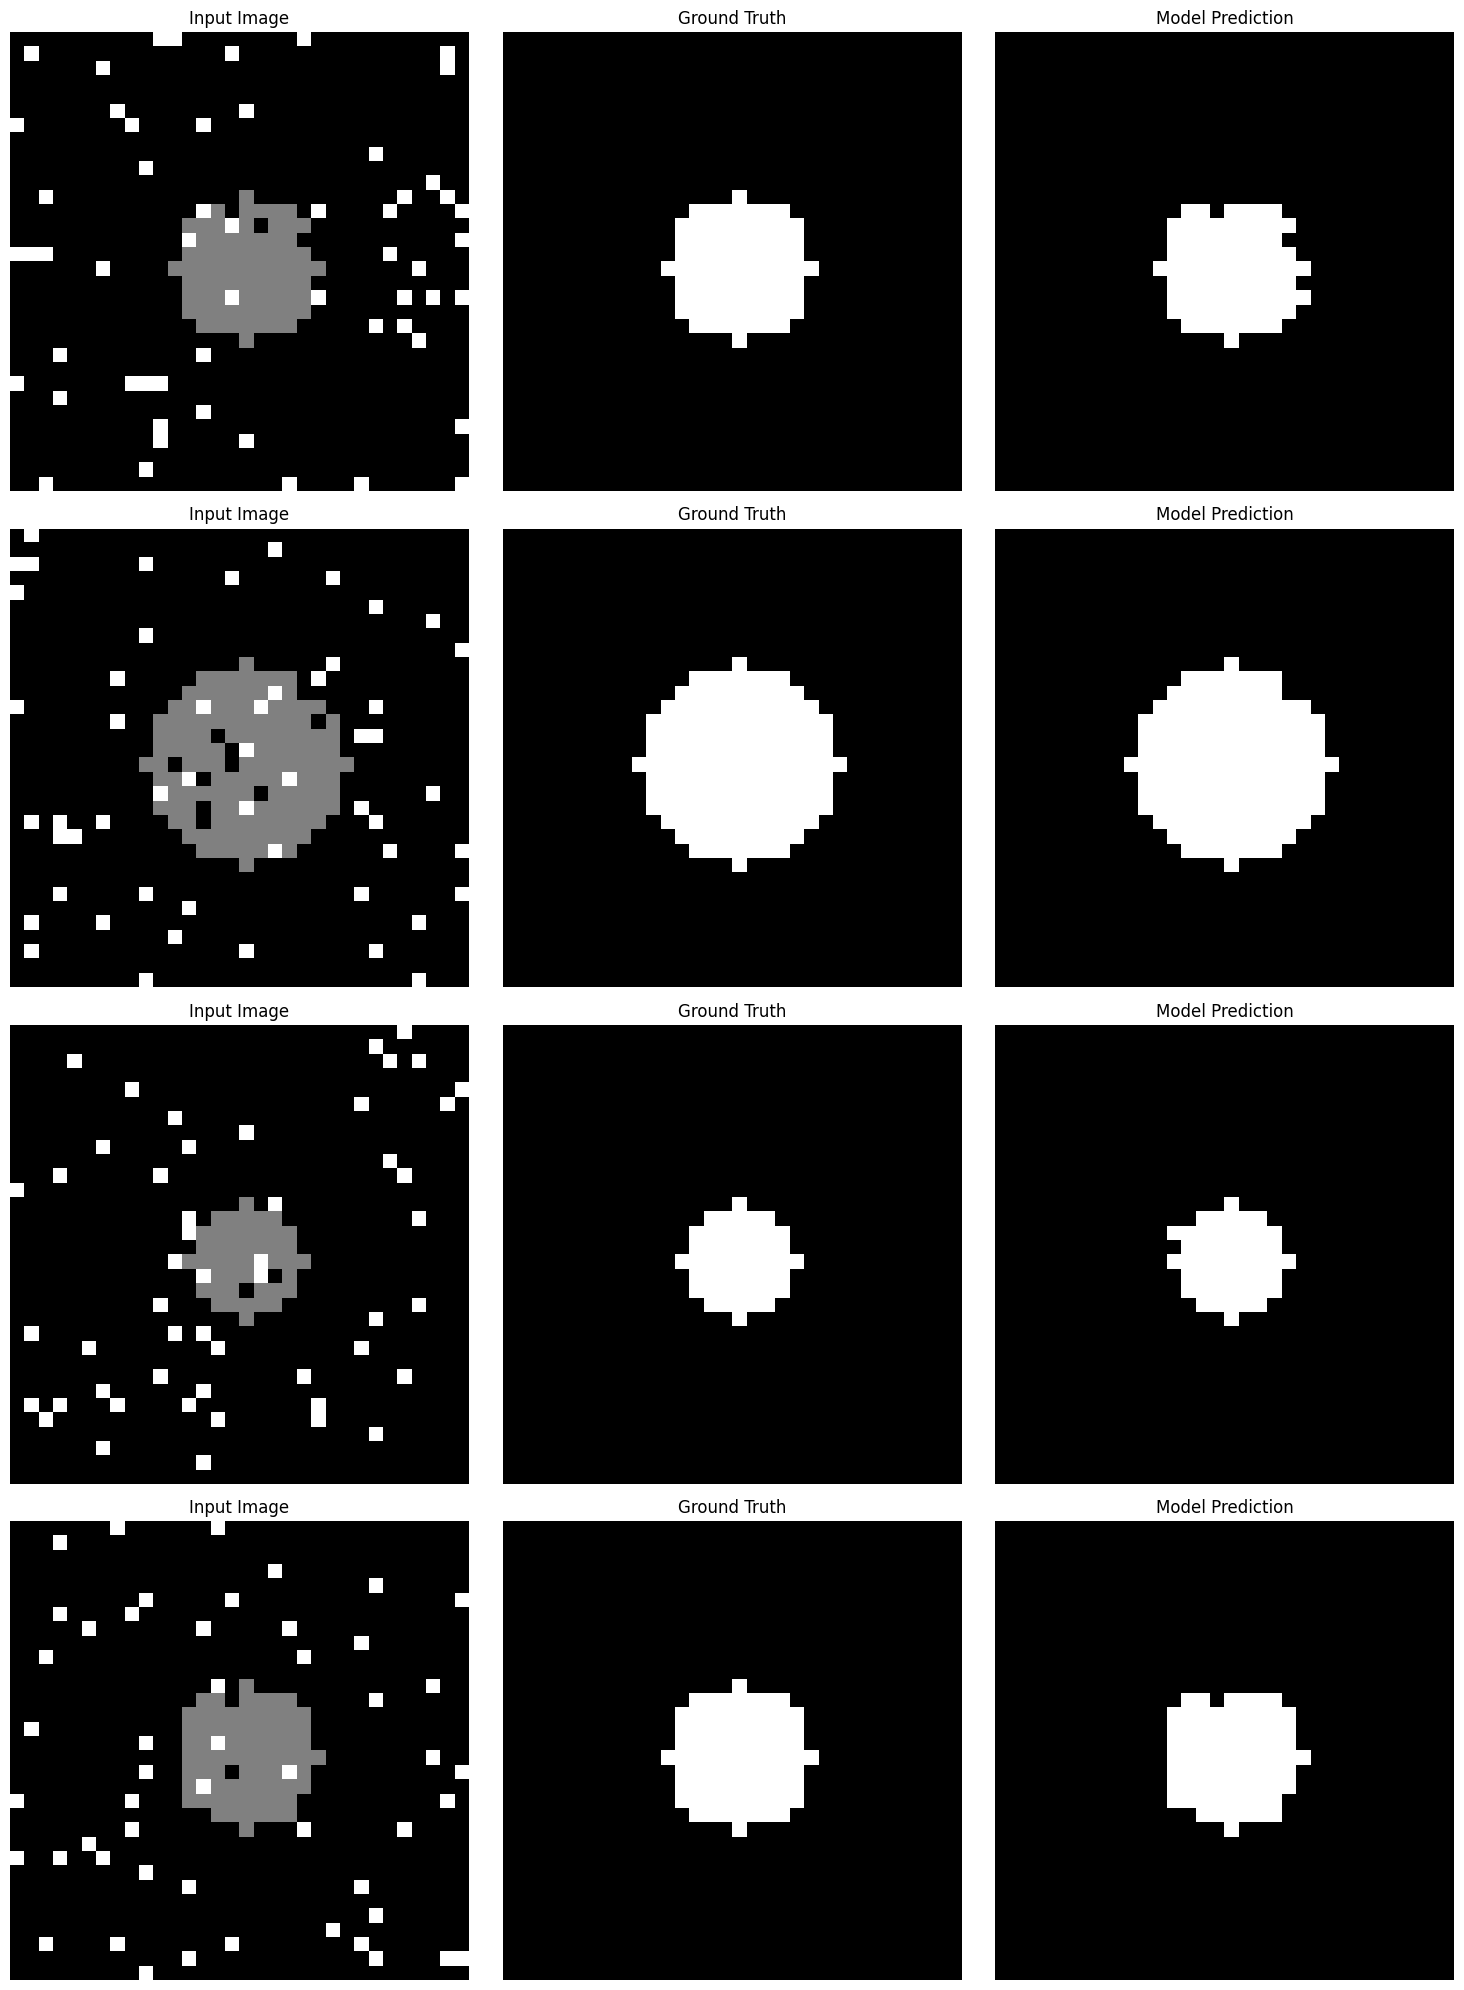

Epoch [41/50], Loss: 0.2149
Epoch [42/50], Loss: 0.2120
Epoch [43/50], Loss: 0.2139
Epoch [44/50], Loss: 0.1789
Epoch [45/50], Loss: 0.1715
Epoch [46/50], Loss: 0.1836
Epoch [47/50], Loss: 0.1858
Epoch [48/50], Loss: 0.1625
Epoch [49/50], Loss: 0.1521
Epoch [50/50], Loss: 0.1262


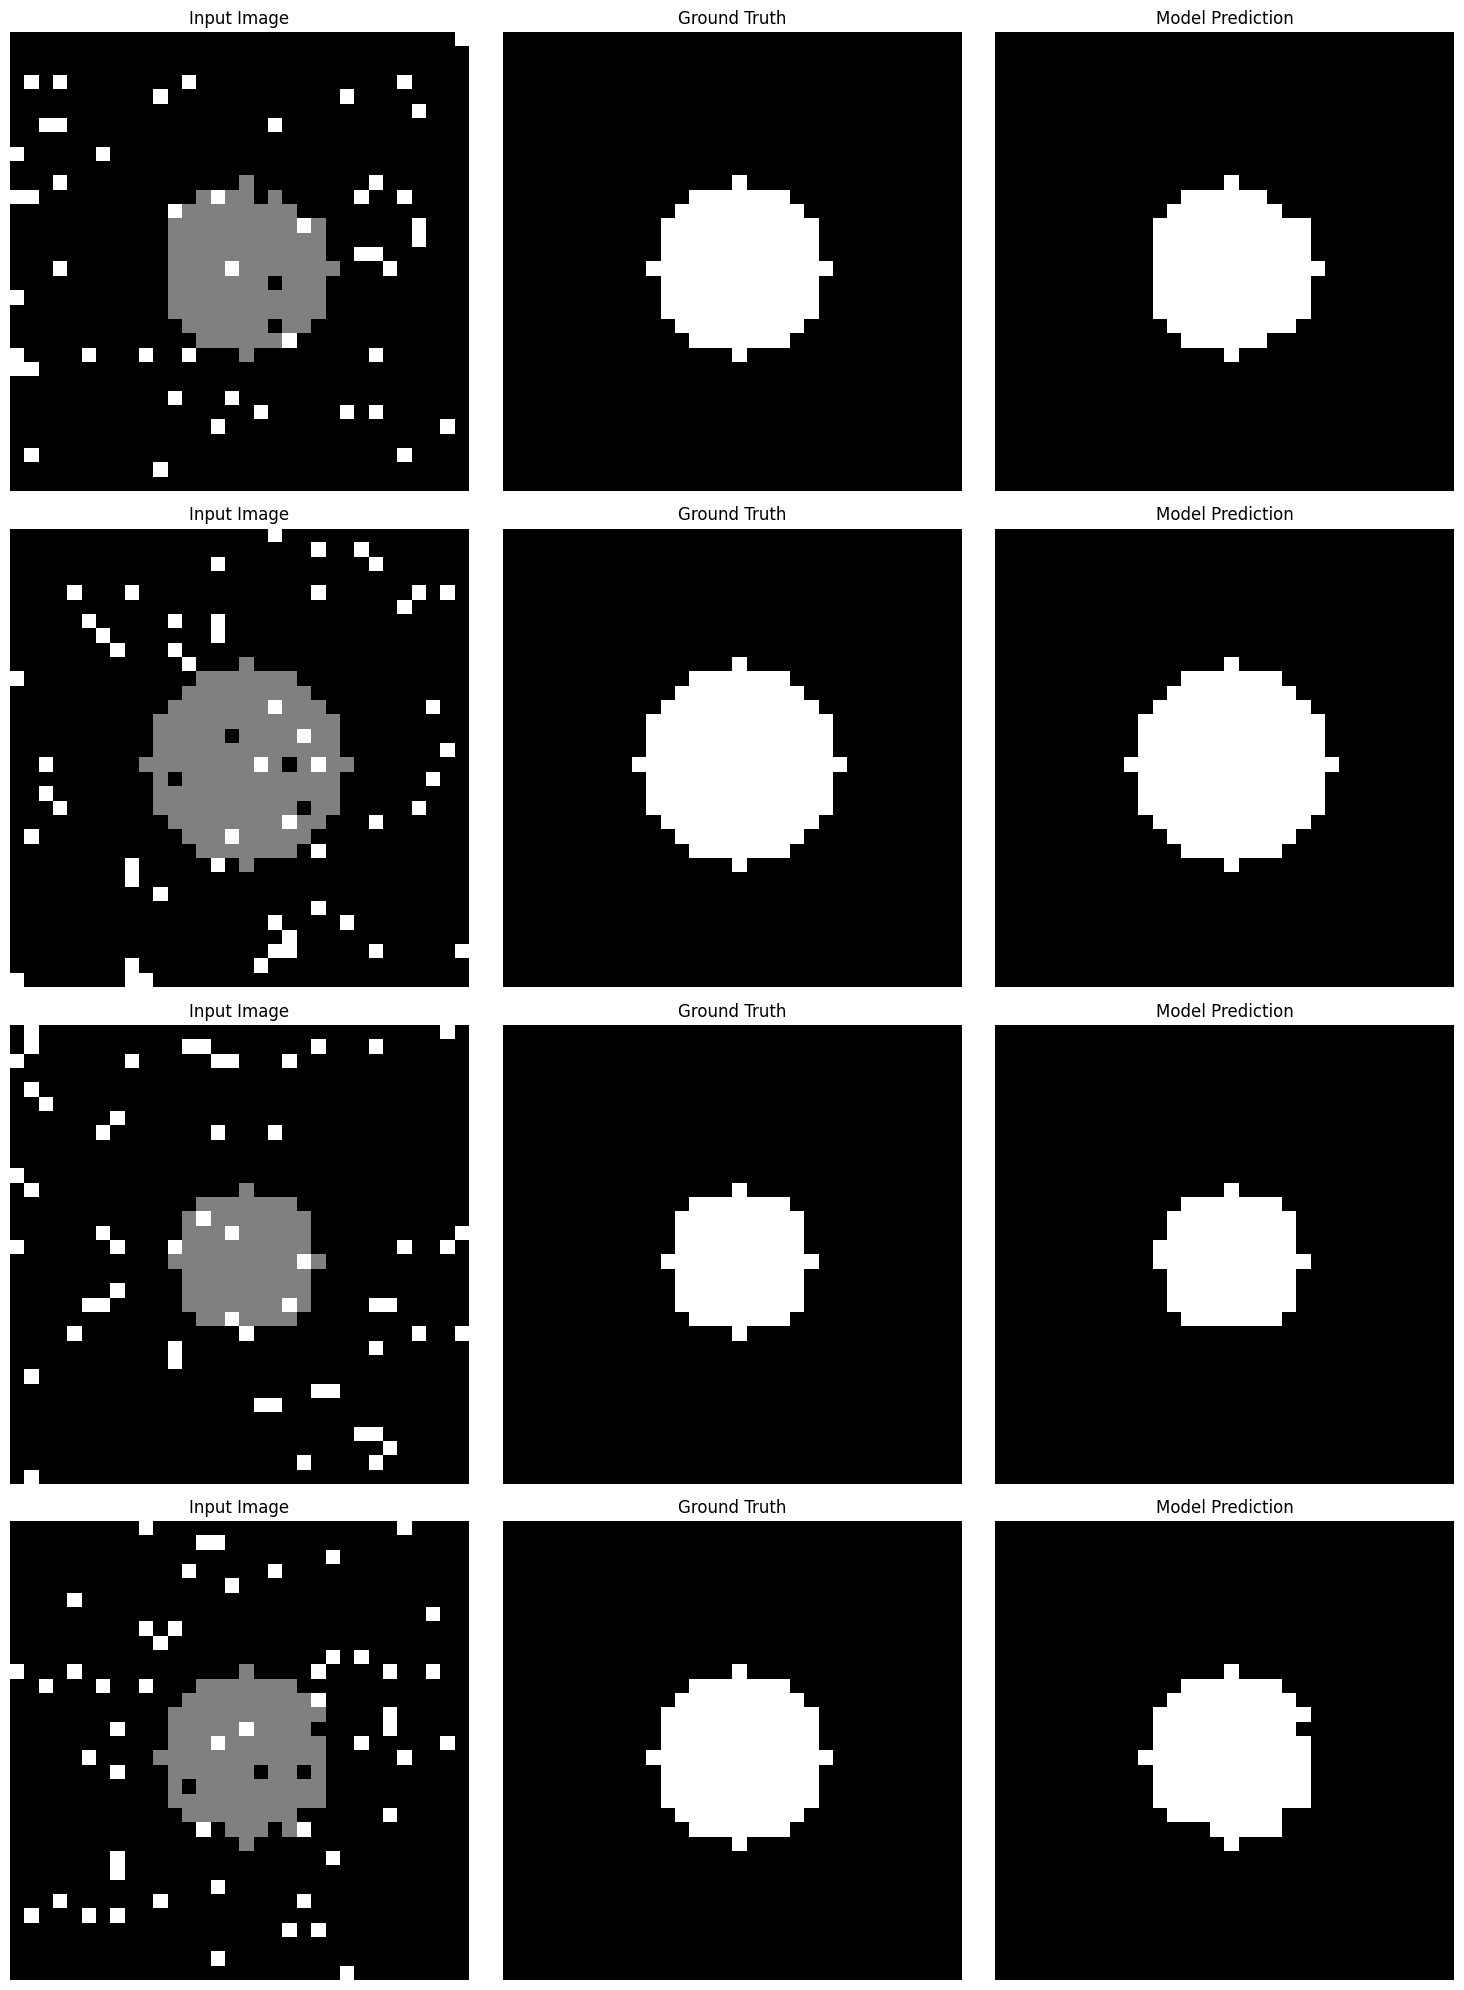

Normal Training completed!
Dice score: 0.9891780018806458


In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 16
num_epochs = 50
learning_rate = 0.001

# MedDecathalon dataset Task04_Hippocampus
# dataset = SegmentationDataset()
dataset = PerturbedSegmentationDataset()
# dataset = SegmentationGaussianDataset()

# Split dataset into training and test sets
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% for training
test_size = total_size - train_size  # Remaining 20% for test

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
# model = SmallUNet(in_channels=1, out_channels=1).to(device)
model = BigUNet(in_channels=1, out_channels=1).to(device)

criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train(model, train_loader, criterion, optimizer, device, num_epochs)
print("Normal Training completed!")

# Calculate the dice score
dice_score = calculate_dice_score(model, test_loader, device)
print(f"Dice score: {dice_score}")
